In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, f1_score  # Added F1-score
from sklearn.impute import SimpleImputer 
import zipfile
import os

In [36]:
import zipfile
import os
import pandas as pd

# Define the paths for the zip files
zip_path = 'bank_data/bank+marketing.zip'  # Outer ZIP file
inner_zip_path = 'bank-additional.zip'  # Inner ZIP file
extract_to = 'bank_data/bank-additional'  # Directory to extract outer ZIP file
extract_inner_to = 'bank_data/bank-additional/extracted'  # Directory for inner ZIP extraction

# Create the extraction directory if it doesn't exist
os.makedirs(extract_to, exist_ok=True)
os.makedirs(extract_inner_to, exist_ok=True)

# Extract the outer ZIP file (bank.zip)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extract(inner_zip_path, extract_to)

print(f"Extracting {inner_zip_path} from {zip_path} to {extract_to}")

# Now extract the inner ZIP file (bank-additional.zip)
with zipfile.ZipFile(f'{extract_to}/{inner_zip_path}', 'r') as zip_ref:
    zip_ref.extractall(extract_inner_to)

print(f"Inner files extracted to: {extract_inner_to}")
print(f"Inner files extracted: {os.listdir(extract_inner_to)}")

# Files in the bank-additional folder
print(f"Files in bank-additional folder: {os.listdir(extract_to)}")

# Load the dataset
df = pd.read_csv(f'{extract_inner_to}/bank-additional/bank-additional-full.csv', sep=';')

# Display the first few rows of the dataset
print(df.head())


Extracting bank-additional.zip from bank_data/bank+marketing.zip to bank_data/bank-additional
Inner files extracted to: bank_data/bank-additional/extracted
Inner files extracted: ['bank-additional', '__MACOSX']
Files in bank-additional folder: ['bank-additional', 'bank-additional.zip', 'extracted', '__MACOSX']
   age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent     

In [38]:

# Convert target variable to binary (yes=1, no=0)
df['y'] = df['y'].map({'yes': 1, 'no': 0})

# Identify categorical columns
cat_cols = df.select_dtypes(include=['object']).columns

# Apply One-Hot Encoding
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Check for missing values
print("\nMissing Values:\n", df.isnull().sum())



Missing Values:
 age                              0
duration                         0
campaign                         0
pdays                            0
previous                         0
emp.var.rate                     0
cons.price.idx                   0
cons.conf.idx                    0
euribor3m                        0
nr.employed                      0
y                                0
job_blue-collar                  0
job_entrepreneur                 0
job_housemaid                    0
job_management                   0
job_retired                      0
job_self-employed                0
job_services                     0
job_student                      0
job_technician                   0
job_unemployed                   0
job_unknown                      0
marital_married                  0
marital_single                   0
marital_unknown                  0
education_basic.6y               0
education_basic.9y               0
education_high.school            0
ed

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split


X = df.drop(columns=["y", "duration"])  # as mentioned in data prep, we will drop this
y = df["y"]

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


In [42]:
# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [25]:
from sklearn.model_selection import cross_val_score

cv_scores = []

for k in range(1, 10):  # Test k from 1 to 20
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=3, scoring='accuracy')  # 3-fold cross-validation
    cv_scores.append(scores.mean())

# Find the best k
best_k = np.argmax(cv_scores) + 1  # Adding 1 because index starts from 0
print(f"Best k: {best_k}")



Best k: 1


In [26]:
# Train the model using the best k
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_scaled, y_train)


KNeighborsClassifier(n_neighbors=1)

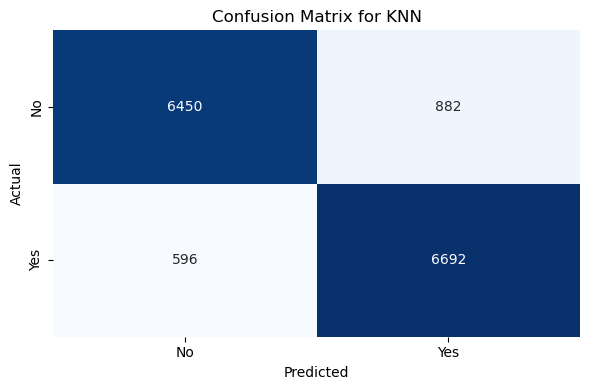

Accuracy: 0.8989 | Precision: 0.8835 | Recall: 0.9182 | F1-Score: 0.9006

--- Prediction Results ---
Correct Predictions: 13142
Incorrect Predictions: 1478
  False Positives: 882
  False Negatives: 596
  True Positives: 6692
  True Negatives: 6450


In [80]:

from sklearn.metrics import confusion_matrix, accuracy_score , precision_score, recall_score, f1_score
y_pred = knn.predict(X_test_scaled)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)


# Calculate metrics for the confusion matrix
TP = conf_matrix[1, 1]  # True Positive
TN = conf_matrix[0, 0]  # True Negative
FP = conf_matrix[0, 1]  # False Positive
FN = conf_matrix[1, 0]  # False Negative

# Calculate additional metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Calculate percentage for each cell in the confusion matrix
total = conf_matrix.sum()
conf_matrix_percent = conf_matrix / total * 100


# Plot confusion matrix with both raw counts and percentages
fig, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"], cbar=False)


# Display confusion matrix title
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix for KNN")

# Adjust layout to ensure that everything fits without overlap
plt.tight_layout()

plt.show()

# Print performance metrics separately
print(f"Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1-Score: {f1:.4f}")

# Print counts for correct and incorrect predictions
print("\n--- Prediction Results ---")
print(f"Correct Predictions: {TP + TN}")
print(f"Incorrect Predictions: {FP + FN}")
print(f"  False Positives: {FP}")
print(f"  False Negatives: {FN}")
print(f"  True Positives: {TP}")
print(f"  True Negatives: {TN}")

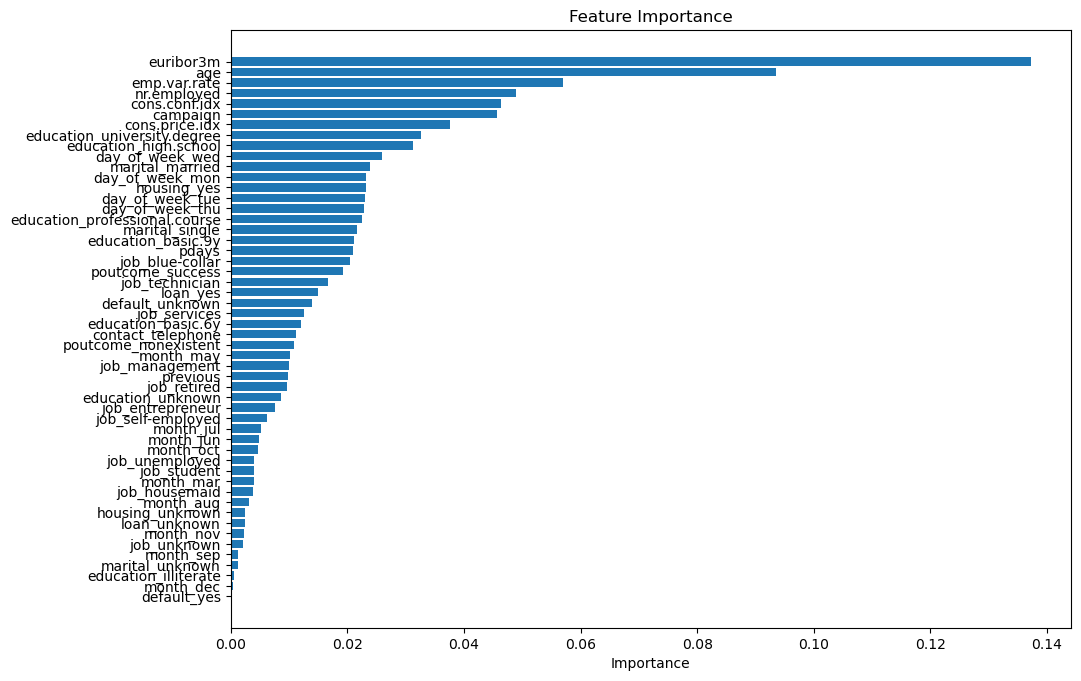

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier


clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# get feature importances
feature_importances = clf.feature_importances_

features = X_train.columns
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

# sort features by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8)) 
plt.barh(importance_df['Feature'], importance_df['Importance'])


plt.gca().invert_yaxis()  # This inverts the y-axis so the highest importance is at the top

plt.xlabel('Importance')
plt.title('Feature Importance')

plt.tight_layout(pad=5.0)
plt.show()


In [98]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np


X_test_no_duration = X_test.copy()
if 'duration' in X_test_no_duration.columns:
    X_test_no_duration['duration'] = 0  # Neutralize duration (or you can drop it instead)

# Extract one-hot encoding columns for education, marital, and poutcome
education_columns = [col for col in X_test.columns if col.startswith('education_')]
marital_columns = [col for col in X_test.columns if col.startswith('marital_')]
poutcome_columns = [col for col in X_test.columns if col.startswith('poutcome_')]

# Function to extract all education categories for a given profile
def extract_all_education_categories(profile, education_columns):
    education_values = []
    for col in education_columns:
        category = col.replace("education_", "")
        if profile[col] == 1:
            education_values.append(category)
    return education_values if education_values else ["Unknown"]

# Assuming you have already trained your KNN model as `knn`
# Get the predicted probabilities for class 1 (subscribed) without the 'duration' feature
y_pred_proba_no_duration = knn.predict_proba(X_test_no_duration)[:, 1]

# Example: Select top 5 clients with the highest predicted probability to subscribe
top_responders_no_duration = np.argsort(y_pred_proba_no_duration)[::-1][:5]  # Top 5 highest probabilities

# Convert positional indices to actual DataFrame indices
top_indices = X_test.iloc[top_responders_no_duration].index  # Get corresponding DataFrame indices

# Display profiles of the top 5 clients
for i, index in enumerate(top_indices, 1):  # Use actual indices
    profile = X_test.loc[index]  # Get profile using .loc
    actual_value = y_test.loc[index]  # Match index in y_test
    probability = y_pred_proba_no_duration[top_responders_no_duration[i - 1]]  # Get probability for the profile

    # Convert actual value (y) to "Yes" or "No"
    actual_value_str = 'Yes' if actual_value == 1 else 'No'

    # Extract education categories
    education_categories = extract_all_education_categories(profile, education_columns)

    # Extract marital and poutcome categories
    marital_category = next((col.replace("marital_", "") for col in marital_columns if profile[col] == 1), "Unknown")
    poutcome_category = next((col.replace("poutcome_", "") for col in poutcome_columns if profile[col] == 1), "Unknown")

    # Print structured output
    print(f"--- Profile {i} ---")
    print(f"Index: {index}")
    print(f"Actual Value: {actual_value_str}")
    print(f"Predicted Probability: {probability:.4f}")
    print(f"Education: {', '.join(education_categories)}")
    print(f"Marital Status: {marital_category}")
    print(f"Poutcome: {poutcome_category}")
    print("\n")


X has feature names, but KNeighborsClassifier was fitted without feature names


--- Profile 1 ---
Index: 49562
Actual Value: Yes
Predicted Probability: 1.0000
Education: university.degree
Marital Status: married
Poutcome: nonexistent


--- Profile 2 ---
Index: 24629
Actual Value: No
Predicted Probability: 1.0000
Education: university.degree
Marital Status: married
Poutcome: nonexistent


--- Profile 3 ---
Index: 69454
Actual Value: Yes
Predicted Probability: 1.0000
Education: university.degree
Marital Status: married
Poutcome: nonexistent


--- Profile 4 ---
Index: 50386
Actual Value: Yes
Predicted Probability: 1.0000
Education: basic.9y, university.degree
Marital Status: married
Poutcome: Unknown


--- Profile 5 ---
Index: 72260
Actual Value: Yes
Predicted Probability: 1.0000
Education: university.degree, unknown
Marital Status: married
Poutcome: success


